In [1]:
# importing lib/etc
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('segmentation data.csv', index_col='ID')

In [3]:
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
df.columns = df.columns.str.replace(' ', '_')
df.columns = map(str.lower, df.columns)

In [5]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
sex,2000.0,0.4570,0.498272,0.0,0.00,0.0,1.00,1.0
marital_status,2000.0,0.4965,0.500113,0.0,0.00,0.0,1.00,1.0
age,2000.0,35.9090,11.719402,18.0,27.00,33.0,42.00,76.0
education,2000.0,1.0380,0.599780,0.0,1.00,1.0,1.00,3.0
income,2000.0,120954.4190,38108.824679,35832.0,97663.25,115548.5,138072.25,309364.0
occupation,2000.0,0.8105,0.638587,0.0,0.00,1.0,1.00,2.0
settlement_size,2000.0,0.7390,0.812533,0.0,0.00,1.0,1.00,2.0


In [6]:
df.isnull().sum()

sex                0
marital_status     0
age                0
education          0
income             0
occupation         0
settlement_size    0
dtype: int64

In [7]:
df.corr().style.background_gradient(cmap='viridis')

,sex,marital_status,age,education,income,occupation,settlement_size
sex,1,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
marital_status,0.566511,1,-0.213178,0.374017,-0.0735277,-0.0294896,-0.0970406
age,-0.182885,-0.213178,1,0.654605,0.34061,0.108388,0.119751
education,0.244838,0.374017,0.654605,1,0.233459,0.0645238,0.0347323
income,-0.195146,-0.0735277,0.34061,0.233459,1,0.680357,0.490881
occupation,-0.202491,-0.0294896,0.108388,0.0645238,0.680357,1,0.571795
settlement_size,-0.300803,-0.0970406,0.119751,0.0347323,0.490881,0.571795,1


In [8]:
# for col in ['sex', 'marital_status', 'education', 'occupation', 'settlement_size']:
#     df[col] = df[col].astype('category')

In [9]:
px.defaults.color_continuous_scale = px.colors.sequential.Viridis
# px.defaults.color_discrete_sequence = px.colors.qualitative.Prism
px.defaults.template = 'plotly_white'

In [10]:
px.scatter_matrix(df, width=1000, height=1000)

In [11]:
px.scatter(df, x='age', y='income', color='occupation')

## Standardization

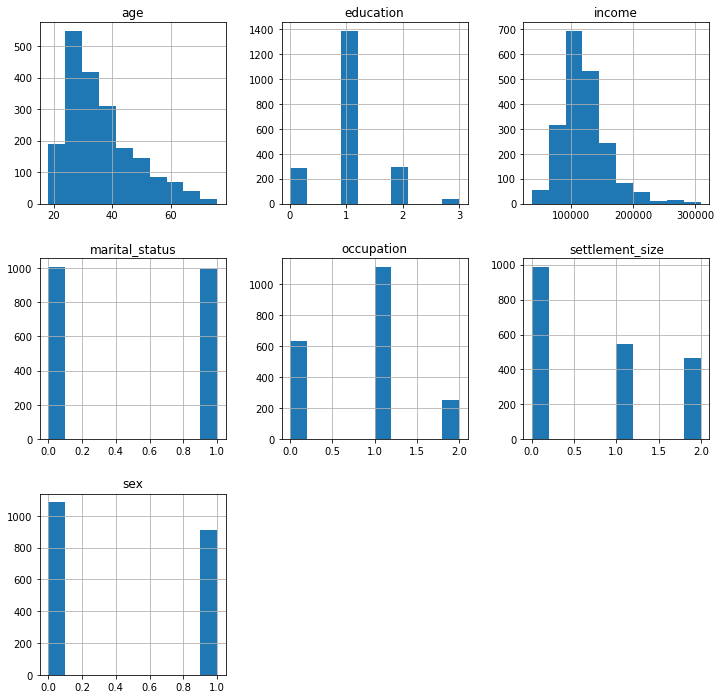

In [12]:
df.hist(figsize=(12, 12));

In [13]:
dfss = df.copy()

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
ss = StandardScaler()

In [16]:
dfss[dfss.columns] = ss.fit_transform(dfss)

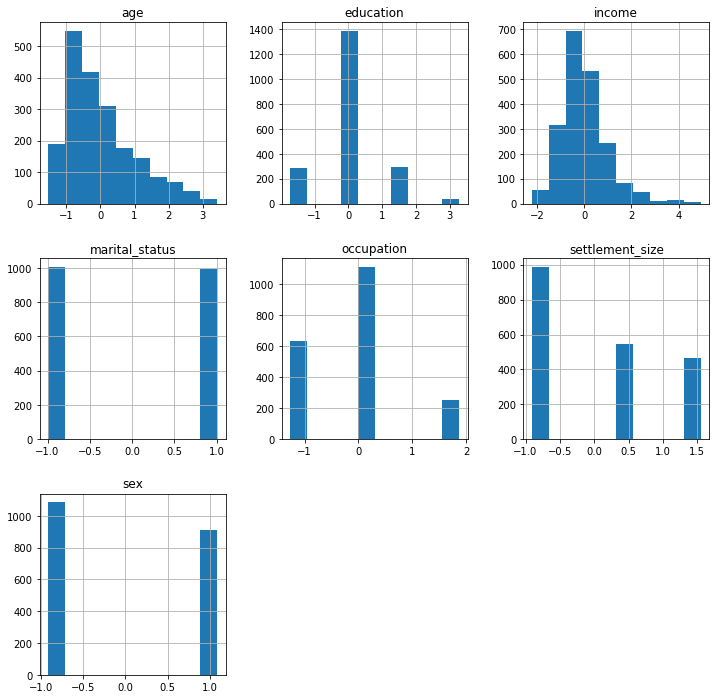

In [17]:
dfss.hist(figsize=(12, 12));

# Hierarchical Clustering

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [19]:
hier_clust = linkage(dfss, method='ward')

In [20]:
dfss.shape

(2000, 7)

In [21]:
hier_clust.shape

(1999, 4)

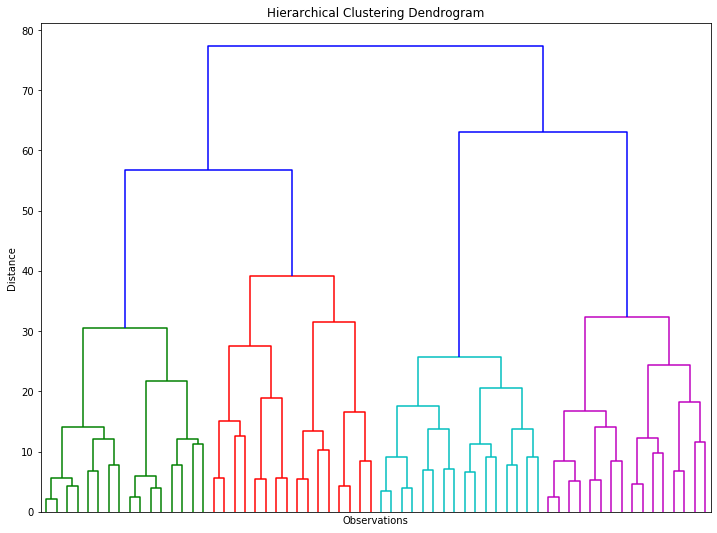

In [22]:
plt.figure(figsize=(12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust, 
           show_leaf_counts=False,
           truncate_mode='level',
           p=5,
           no_labels=True)
plt.show()

# K-Means Clustering

In [23]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

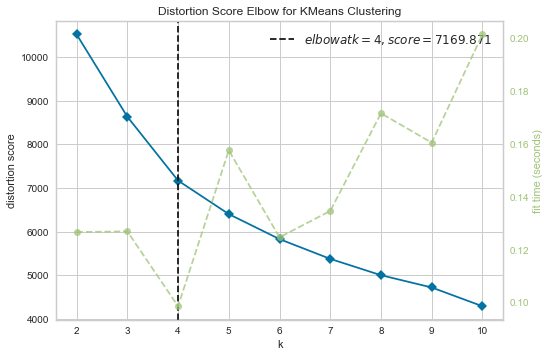

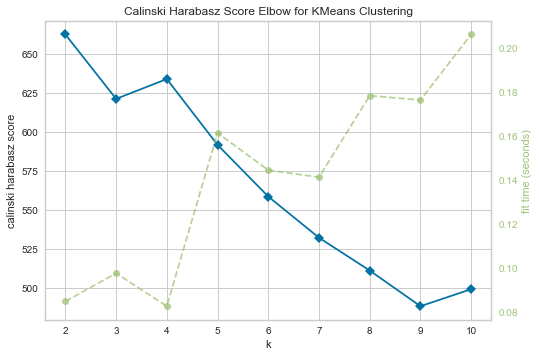

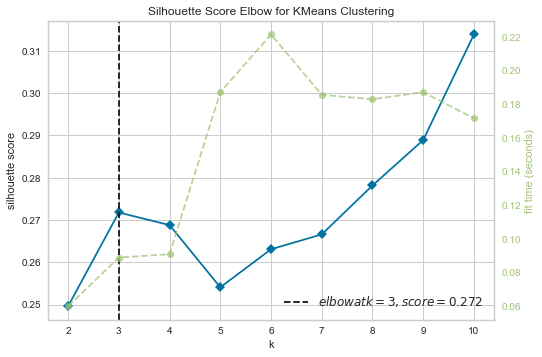

In [24]:
kmeans = KMeans(init='k-means++', random_state=42)
KElbowVisualizer(model=kmeans, k=10, metric='distortion').fit(dfss).show()
KElbowVisualizer(model=kmeans, k=10, metric='calinski_harabasz').fit(dfss).show()
KElbowVisualizer(model=kmeans, k=10, metric='silhouette').fit(dfss).show()

In [25]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(dfss)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [33]:
df['kmeans_label'] = kmeans.labels_

In [38]:
df.groupby('kmeans_label').mean().T

kmeans_label,0,1,2,3
sex,0.501901,0.352814,0.853901,0.029825
marital_status,0.692015,0.019481,0.997163,0.173684
age,55.703422,35.577922,28.963121,35.635088
education,2.129278,0.746753,1.068085,0.733333
income,158338.422053,97859.852814,105759.119149,141218.249123
occupation,1.129278,0.329004,0.634043,1.271930
settlement_size,1.110266,0.043290,0.422695,1.522807


## Interpretation of the clusters

**Cluster 0/Well-off**: It is composed of mean and women equally. More than 2/3 of them are married and their mean age is 55 and by comparing this to other segments, we can see this is the oldest segment. Also their mean income is 158k which is the highest between all clusters.

**Cluster 1/Fewer-Opportunities**: 2/3 are males, nearly all non-married, mean age 35 and they have the lowes income mean of 97k.  Based on their settlement_size, they also live small cities.

**Cluster 2/Standard**: Mostly in relationship/married, with the mean age of 28 (youngest group), medium education.  They sem to be average in most categories.  

**Cluster 3/Career-Focused**: This group seems to be entirely men, lower valuesn in education and higher values for income, occupation, and settlement size.  



In [39]:
df['segment'] = df['kmeans_label'].map({0:'Well-off',
                                        1:'Fewer-Opportunities',
                                        2:'Standard',
                                        3:'Career-Focused'})

In [40]:
df['segment'].value_counts()

Standard               705
Career-Focused         570
Fewer-Opportunities    462
Well-off               263
Name: segment, dtype: int64

In [42]:
df['segment'].value_counts(normalize=True)*100

Standard               35.25
Career-Focused         28.50
Fewer-Opportunities    23.10
Well-off               13.15
Name: segment, dtype: float64

In [43]:
px.scatter_matrix(df, color='segment', width=1200, height=1200)

In [44]:
px.scatter(df, x='age', y='income', color='segment')

Seems that clustering is doing a good job separating the Well-off segment from other clusters, yet on the other clusters there is too much overlap.

In [48]:
px.parallel_coordinates(df, color='kmeans_label', width=1000, height=800, 
                        dimensions=['sex', 'marital_status', 'education', 'occupation',
                                    'age','settlement_size', 'income'])

In [51]:
px.parallel_categories(df, color='kmeans_label' , width=1000, height=800)

# K-Means + PCA

In [52]:
from sklearn.decomposition import PCA

In [98]:
pca = PCA()
pca.fit(dfss)

## Cumulative Sum

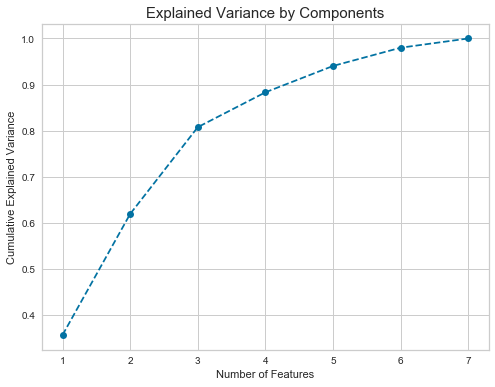

In [140]:
plt.figure(figsize=(8, 6))
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components', size=15);

It seems that by 4 features, we can acheieve near 90 % of the explained variation.


It seems that by 3 features, we can acheieve 80 % of the explained variation.



## PCA Projection

## PCA Biplot

The PCA projection can be enhanced to a biplot whose points are the projected instances and whose vectors represent the structure of the data in high dimensional space. By using proj_features=True, vectors for each feature in the dataset are drawn on the scatter plot in the direction of the maximum variance for that feature. These structures can be used to analyze the importance of a feature to the decomposition or to find features of related variance for further analysis. [taken from yellowbrick guide](https://www.scikit-yb.org/en/latest/api/features/pca.html)

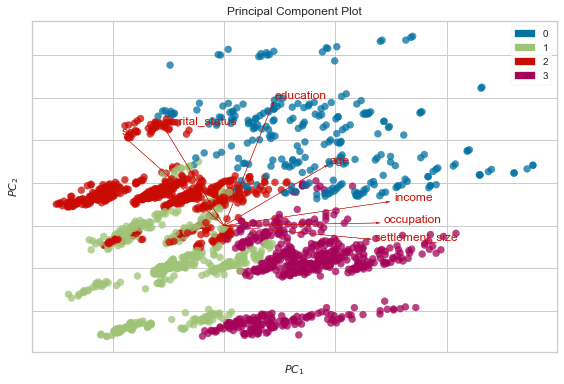

In [145]:
from yellowbrick.features import PCA

# Load the concrete dataset
X, y = dfss, df.kmeans_label

pca_biplot = PCA(scale=True, proj_features=True)
pca_biplot.fit_transform(X, y)
pca_biplot.show();

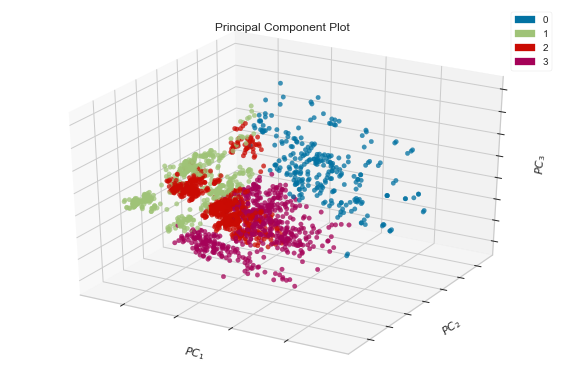

In [146]:
pca_3d = PCA(
    scale=True, projection=3
)
pca_3d.fit_transform(X, y)
pca_3d.show()

In [148]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(dfss)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [153]:
pca.components_.shape

(3, 7)

In [162]:
df_pca_comp = pd.DataFrame(pca.components_, 
                            columns=dfss.columns,
                            index=['component 1', 'component 2', 'component 3'])
df_pca_comp

,sex,marital_status,age,education,income,occupation,settlement_size
component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


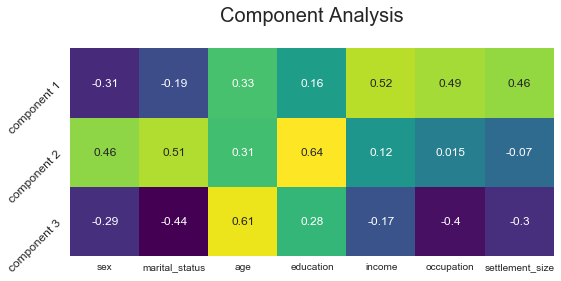

In [217]:
fig = sns.heatmap(df_pca_comp, annot=True, square=True, cmap='viridis',
                 cbar=False)
fig.set_ylim(len(df_pca_comp),-0.3)
plt.yticks(rotation=45, fontsize=12)
plt.title('Component Analysis', size=20)
plt.tight_layout()


## Interpretation
**Component 1**: Seems to be a positive correlation between education, income, occupation, and settlement size - These can be related to career of a person so most of them go towards the career focused group.

**Component 2**: sex, marital_status, and education are the most prominent. Addtionally, almost all career related fertures are uncorrelated with this component. Therefore, this component mostly correlates with an individual's life style.

**Component 3**: age, marital_status and occupation are the most prominent and age and occupation actually have a negative correlation. We can interpret this as the experience an individual has no matter the life or work experience.



In [219]:
scores_pca = pca.transform(dfss)

## K-Means + PCA

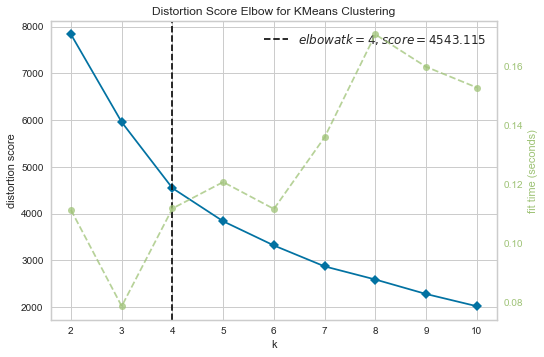

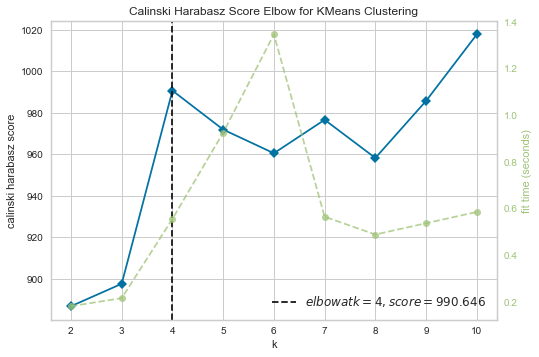

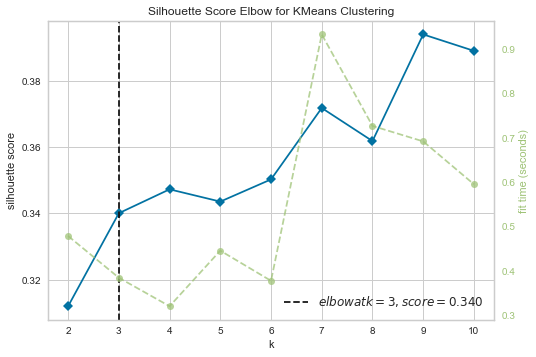

In [221]:
kmeans_pca = KMeans(init='k-means++', random_state=42)
KElbowVisualizer(model=kmeans_pca, k=10, metric='distortion').fit(scores_pca).show()
KElbowVisualizer(model=kmeans_pca, k=10, metric='calinski_harabasz').fit(scores_pca).show()
KElbowVisualizer(model=kmeans_pca, k=10, metric='silhouette').fit(scores_pca).show()

It seems that still 4 clusters is a good number to work with

In [223]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [231]:
df_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_pca.columns.values[-3: ] = ['component_1', 'component_2', 'component_3']
df_pca['kmeans_pca_label'] = kmeans_pca.labels_

In [234]:
df_pca.groupby('kmeans_pca_label').mean().T

kmeans_pca_label,0,1,2,3
sex,0.900289,0.027444,0.306522,0.505660
marital_status,0.965318,0.168096,0.095652,0.690566
age,28.878613,35.737564,35.313043,55.679245
education,1.060694,0.734134,0.760870,2.128302
income,107551.500000,141525.826758,93692.567391,158019.101887
occupation,0.677746,1.267581,0.252174,1.120755
settlement_size,0.440751,1.480274,0.039130,1.101887
kmeans_label,1.972543,2.941681,1.084783,0.011321
component_1,-1.107019,1.372663,-1.046406,1.687328
component_2,0.703776,-1.046172,-0.902963,2.031200
